Example taken from Google ML Crash Course:
https://developers.google.com/machine-learning/crash-course/feature-crosses/encoding-nonlinearity

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

import tensorflow as tf 

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# pd.show_versions()

## Linear Problem

### Create the DataSet

50 data points per category

In [2]:
N = 50

Create the random data set for sick trees

Scale and shift the (0, 1) range from np.random.random to (-5, 5) respectively (0, 5)

See also here: https://stackoverflow.com/questions/59389241/how-to-generate-a-random-float-in-range-1-1-using-numpy-random-rand

In [13]:
max_x, min_x = 5, -5
range_size = (max_x - min_x)
sick_x = np.random.random([N]) * range_size + min_x

max_y, min_y = 0, -5
range_size = (max_y - min_y)
sick_y = np.random.random([N]) * range_size + min_y

[-4.84956525 -2.85371734 -0.50171978 -2.52673354 -2.25391201 -4.9456033
 -2.14393915 -4.55796001 -2.29950908 -2.24672767 -1.93349854 -0.0131529
 -3.50071321 -3.51114116 -1.67074047 -3.34630727 -0.91701513 -3.21188051
 -2.55359666 -0.5858691  -4.81532679 -1.97945269 -0.33106983 -1.34363013
 -4.72174584 -0.14026285 -3.78101501 -0.62924043 -2.39427815 -4.94863469
 -3.89462399 -0.4065146  -1.08289648 -4.91176141 -2.86580973 -4.58923262
 -4.14964036 -2.19537966 -2.17856825 -3.37466092 -0.75280889 -2.26900782
 -3.45337351 -2.63220367 -0.86763759 -4.2459534  -4.49076296 -2.86044641
 -3.75562469 -2.5677855 ]


Create the randomn data set for healthy trees

In [15]:
max_x, min_x = 5, -5
range_size = (max_x - min_x)
healthy_x = np.random.random([N]) * range_size + min_x

max_y, min_y = 5, 0
range_size = (max_y - min_y)
healthy_y = np.random.random([N]) * range_size + min_y

Plot the data

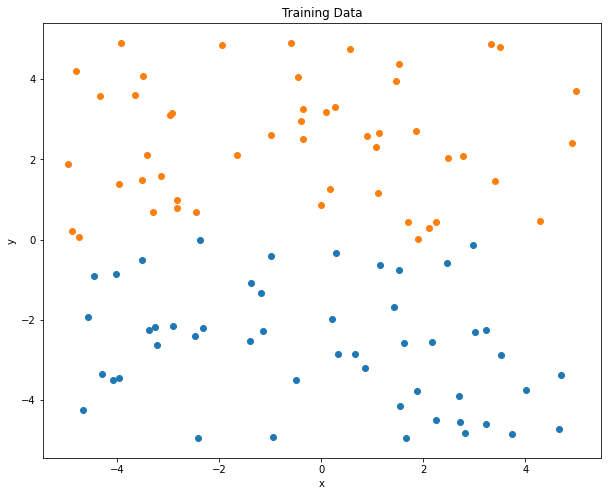

In [16]:
plt.figure(figsize=(10, 8))

plt.scatter(sick_x, sick_y)
plt.scatter(healthy_x, healthy_y)

plt.xlabel('x') 
plt.ylabel('y') 

plt.title("Training Data") 
plt.show() 

Create the Pandas DataFrame

In [18]:
# combine the x and y arrays
sick_trees = np.vstack((sick_x, sick_y)).T
healthy_trees = np.vstack((healthy_x, healthy_y)).T

data_column_names = ['x', 'y']

df_sick = pd.DataFrame(data=sick_trees, columns=data_column_names)
df_sick['status'] = 1

df_healthy = pd.DataFrame(data=healthy_trees, columns=data_column_names)
df_healthy['status'] = 0

# append is deprecated since pandas 1.4.0
# train_df = df_sick.append(df_healthy, ignore_index=True)
train_df = pd.concat([df_sick, df_healthy], ignore_index=True)

# Shuffle the examples.
shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index)) 
shuffled_train_df.head(100)

# Print the entire DataFrame
# print(df)

,x,y,status
74,-5.0,1.9,0
99,-3.5,1.5,0
64,4.9,2.4,0
36,1.5,-4.1,1
35,3.2,-4.6,1
...,...,...,...
69,-1.0,2.6,0
96,-0.4,3.3,0
88,-2.9,3.2,0
37,-2.3,-2.2,1


Build and Train Model Functions

In [19]:
#@title Define the functions that build and train a model
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(2,), activation = 'sigmoid'))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model               


def train_model(model, x, y, my_epochs, 
                my_batch_size=None, my_validation_split=0.1):
  """Feed a dataset into the model in order to train it."""

  history = model.fit(x=x,
                      y=y,
                      batch_size=my_batch_size,
                      epochs=my_epochs,
                      validation_split=my_validation_split)

  # Gather the model's trained weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the 
  # rest of history.
  epochs = history.epoch
  
  # Isolate the root mean squared error for each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse, history.history   

print("Defined the build_model and train_model functions.")

Defined the build_model and train_model functions.


Define plotting functions

In [20]:
#@title Define the plotting function

def plot_the_loss_curve(epochs, mae_training, mae_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs[1:], mae_training[1:], label="Training Loss")
  plt.plot(epochs[1:], mae_validation[1:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mae_lists = mae_training[1:] + mae_validation[1:]
  highest_loss = max(merged_mae_lists)
  lowest_loss = min(merged_mae_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


### Train

Epoch 1/1000


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


9/9 [==============================] - 0s 12ms/step - loss: 0.2187 - root_mean_squared_error: 0.4677 - val_loss: 0.2549 - val_root_mean_squared_error: 0.5049
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2137 - root_mean_squared_error: 0.4623 - val_loss: 0.2499 - val_root_mean_squared_error: 0.4999
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2097 - root_mean_squared_error: 0.4579 - val_loss: 0.2456 - val_root_mean_squared_error: 0.4956
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2061 - root_mean_squared_error: 0.4540 - val_loss: 0.2415 - val_root_mean_squared_error: 0.4914
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2024 - root_mean_squared_error: 0.4499 - val_loss: 0.2374 - val_root_mean_squared_error: 0.4872
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1987 - root_mean_squared_error: 0.4457 - val_loss: 0.2333 - val_root_mean_squared_error:

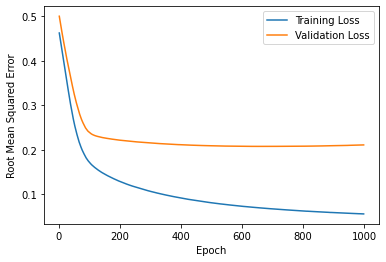


The learned weight for your model is: x1 = 0.0849, x2 = -7.3178
The learned bias for your model is -0.4243



In [35]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 1000
batch_size = 10

# Discard any pre-existing version of the model.
my_model = None

# Invoke the functions.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse, history = train_model(my_model, 
                                        shuffled_train_df.drop('status', axis=1),
                                        shuffled_train_df[['status']],
                                        epochs, batch_size)

plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                    history["val_root_mean_squared_error"])

# print(weight)
print("\nThe learned weight for your model is: x1 = %.4f, x2 = %.4f" % (weight[0], weight[1]))
print("The learned bias for your model is %.4f\n" % bias )

## Prediction

In [36]:
# A few random samples
should_be_healthy = [2., 2.2]
should_be_sick = [2., -1.2]

# Convert into Numpy array
samples_to_predict = np.array([should_be_healthy, should_be_sick])
print(samples_to_predict.shape)

predict = my_model.predict(x=samples_to_predict)
print(predict)

(2, 2)
1/1 [==============================] - 0s 38ms/step
[[7.901605e-08]
 [9.998020e-01]]


## Non-Linear Problem

Create the sample data set

Scale and shift the (0, 1) range from np.random.random to (-5, 5).

See also here: https://stackoverflow.com/questions/59389241/how-to-generate-a-random-float-in-range-1-1-using-numpy-random-rand

In [ ]:
N = 100
max_val, min_val = 5, -5
range_size = (max_val - min_val)  # 2
x = np.random.random([N]) * range_size + min_val
y = np.random.random([N]) * range_size + min_val

In [ ]:
plt.figure(figsize=(10, 8))

plt.scatter(x, y)

plt.xlabel('x') 
plt.ylabel('y') 

plt.title("Training Data") 
plt.show() 